# 4. Fine-Tune Full UNet 3D (v4 - Low LR + Continued Training)

This notebook fine-tunes the **Full 3D UNet** (trained in v3) with a lower learning rate to push the Dice score from ~0.77 to > 0.80.
- **Load Weights**: `../models/unet3d_full.pth` (best model from v3)
- **Learning Rate**: `1e-4` (Initial 0.0001, effectively 10x smaller)
- **Epochs**: 30

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import sys
import scipy.ndimage as ndimage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Copy-Paste Dataset & Model (Must Match Exact Architecture!)
class LIDCPatchDataset(Dataset):
    def __init__(self, data_dir, transform=None, augment=False):
        all_files = sorted(glob.glob(str(Path(data_dir) / "*.npz")))
        self.files = []
        for f in all_files:
            data = np.load(f, allow_pickle=True)
            if 'mask' in data and np.sum(data['mask']) > 0:
                self.files.append(f)
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        data = np.load(path)
        image = data['image'].astype(np.float32)
        mask = data['mask'].astype(np.float32)
        label = np.array([data['label']], dtype=np.float32)

        image = (image - (-1000)) / (400 - (-1000))
        image = np.clip(image, 0, 1)

        if self.augment:
            angle = np.random.uniform(-10, 10) # Smaller rotation for fine-tuning
            image = ndimage.rotate(image, angle, axes=(1, 2), reshape=False, order=1)
            mask = ndimage.rotate(mask, angle, axes=(1, 2), reshape=False, order=0)
            
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=1)
                mask = np.flip(mask, axis=1)
            
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=2)
                mask = np.flip(mask, axis=2)

            image = np.clip(image, 0, 1)

        image = np.expand_dims(image.copy(), axis=0).astype(np.float32)
        mask = np.expand_dims(mask.copy(), axis=0).astype(np.float32)

        return torch.tensor(image), torch.tensor(mask), torch.tensor(label)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class FullUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(128, 256))
        self.up1 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        self.outc = nn.Conv3d(32, out_channels, 1)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        mask = torch.sigmoid(self.outc(u3))
        risk = torch.sigmoid(self.classifier(x4))
        return mask, risk

model = FullUNet3D().to(device)

# Load Pre-trained Weights
weights_path = Path("../models/unet3d_full.pth")
if weights_path.exists():
    model.load_state_dict(torch.load(weights_path))
    print("Parsed weights loaded successfully! starting fine-tuning...")
else:
    print("WARNING: Pre-trained model not found! Starting from scratch (not recommended for fine-tuning).")

Parsed weights loaded successfully! starting fine-tuning...


In [3]:
# Loss & Fine-Tuning Setup
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

DATA_DIR = Path("../data/lidc_patches")
full_dataset_train = LIDCPatchDataset(DATA_DIR, augment=True)
full_dataset_val = LIDCPatchDataset(DATA_DIR, augment=False)

n_total = len(full_dataset_train)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
indices =  torch.randperm(n_total).tolist()
train_indices, val_indices = indices[:n_train], indices[n_train:]

train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset_val, val_indices)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

pos_weight = torch.tensor([3.0]).to(device) # Keeping approx weight from previous run

criterion_seg = DiceLoss()
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Reduced Learning Rate for Fine-Tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [4]:
def compute_dice_score(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    return (2. * intersection + 1) / (pred_bin.sum() + target.sum() + 1)

num_epochs = 30
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [], 'train_acc': [], 'val_acc': []}

print("Starting Fine-Tuning...")

for epoch in range(num_epochs):
    model.train()
    running_loss, running_dice, running_acc = 0.0, 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [FT]")
    
    for images, masks, labels in pbar:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        pred_masks, pred_risk = model(images)
        loss_seg = criterion_seg(pred_masks, masks)
        loss_cls = nn.BCELoss()(pred_risk, labels)
        loss = loss_seg + 0.5 * loss_cls
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_dice += compute_dice_score(pred_masks, masks).item()
        running_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    model.eval()
    val_loss, val_dice, val_acc = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            pred_masks, pred_risk = model(images)
            loss_seg = criterion_seg(pred_masks, masks)
            loss_cls = nn.BCELoss()(pred_risk, labels)
            loss = loss_seg + 0.5 * loss_cls
            val_loss += loss.item()
            val_dice += compute_dice_score(pred_masks, masks).item()
            val_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(val_dice / len(val_loader))
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {history['val_dice'][-1]:.4f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "../models/unet3d_finetuned.pth")
        print(f"Saved Best Model (Loss: {best_val_loss:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

Starting Fine-Tuning...


Epoch 1/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.5200 | Val Loss: 0.4043 | Val Dice: 0.7591
Saved Best Model (Loss: 0.4043)


Epoch 2/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.5889 | Val Loss: 0.3759 | Val Dice: 0.7639
Saved Best Model (Loss: 0.3759)


Epoch 3/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.5280 | Val Loss: 0.3588 | Val Dice: 0.7714
Saved Best Model (Loss: 0.3588)


Epoch 4/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.4918 | Val Loss: 0.4164 | Val Dice: 0.7303


Epoch 5/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.4760 | Val Loss: 0.3926 | Val Dice: 0.7724


Epoch 6/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.5756 | Val Loss: 0.4002 | Val Dice: 0.7715


Epoch 7/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.5270 | Val Loss: 0.3791 | Val Dice: 0.7729


Epoch 8/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.5114 | Val Loss: 0.3739 | Val Dice: 0.7655


Epoch 9/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.4954 | Val Loss: 0.3705 | Val Dice: 0.7651


Epoch 10/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.4855 | Val Loss: 0.3852 | Val Dice: 0.7580


Epoch 11/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.4523 | Val Loss: 0.3682 | Val Dice: 0.7726


Epoch 12/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.4691 | Val Loss: 0.3636 | Val Dice: 0.7789


Epoch 13/30 [FT]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.4184 | Val Loss: 0.3630 | Val Dice: 0.7707
Early stopping!


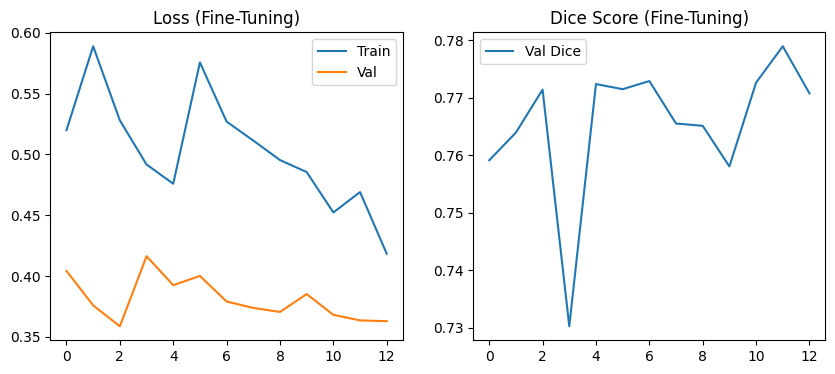

In [5]:
# Plot History
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss (Fine-Tuning)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_dice'], label='Val Dice')
plt.title('Dice Score (Fine-Tuning)')
plt.legend()
plt.show()